In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt



In [2]:
train_batch_size = 128
test_batch_size = 100

In [3]:
def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

In [4]:
def plot_regression(X_train, y_train, X_test, f_test, y_std, plot=True, 
                    file_name='regression_example'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                figsize=(4.5, 2.8))
    ax1.set_title('MAP')
    ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax1.plot(X_test, f_test, color='black', label='$f_{MAP}$')
    ax1.legend()

    ax2.set_title('LA')
    ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax2.plot(X_test, f_test, label='$\mathbb{E}[f]$')
    ax2.fill_between(X_test, f_test-y_std*2, f_test+y_std*2, 
                     alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[y]}$')
    ax2.legend()
    ax1.set_ylim([-4, 6])
    ax1.set_xlim([X_test.min(), X_test.max()])
    ax2.set_xlim([X_test.min(), X_test.max()])
    ax1.set_ylabel('$y$')
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    plt.tight_layout()
    if plot:
        plt.show()
    else:
        plt.savefig(f'docs/{file_name}.png')

In [5]:
n_epochs = 1000
torch.manual_seed(711)
# sample toy data example
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

In [6]:
# create and train MAP model
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

In [7]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

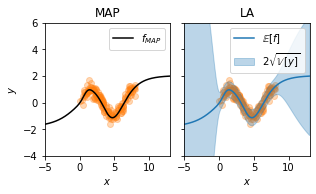

In [8]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

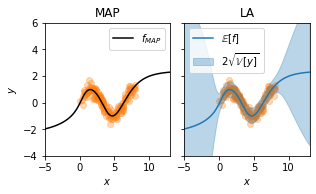

In [9]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)